In [333]:
import numpy as np
import os
import glob
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
from get_sig_cells import get_sig_cells
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import warnings
from astropy.stats import circmean
%matplotlib inline
from astropy.convolution import convolve, convolve_fft
from skimage.morphology import disk




def calculate_firing_rate_by_headdir(headdir, spikes, sync, num_bins=24):
    # Bin the head direction data
    headdir_bins = np.linspace(-180, 180, num_bins + 1)
    headdir_bin_centers = (headdir_bins[:-1] + headdir_bins[1:]) / 2

    # Calculate the occupancy in each bin
    occupancy, _ = np.histogram(headdir, bins=headdir_bins)

    # Calculate the number of spikes in each bin
    spike_headdir = np.interp(spikes, sync, headdir)
    spike_counts, _ = np.histogram(spike_headdir, bins=headdir_bins)

    # Calculate the firing rate in each bin (spikes per bin / occupancy per bin) adjust for 35Hz sampling
    firing_rate = np.divide(spike_counts, occupancy, where=occupancy != 0)*30
    firing_rate[occupancy == 0] = np.nan  # Avoid division by zero

    return headdir_bin_centers, firing_rate, occupancy


def plot_circular_firing_rate(headdir_bin_centers, firing_rate, neuronname=None, ax=None, savepath=None):
    """
    Plots firing rate as a function of head direction in a polar plot.
    If ax is provided, plot on it. Otherwise, create a new figure/axis.
    Optionally save to savepath.
    """
    # Convert head direction to radians
    headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
    width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
        created_fig = True

    bars = ax.bar(headdir_bin_centers_rad, firing_rate, width=width, bottom=0.0, alpha=0.8)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    if neuronname:
        ax.set_title(f'Firing Rate by Head Direction\n{neuronname}')
    # You can add more styling or colorbars here if needed

    plt.tight_layout()

    if savepath is not None:
        if created_fig:
            plt.savefig(savepath, dpi=300)
        else:
            ax.figure.savefig(savepath, dpi=300)

    # Only show if we created the figure in here (avoids showing it when used as a subplot)
    if created_fig:
        plt.show()
        return fig, ax
    else:
        return ax


def resultant_vector_length(alpha, w=None, d=None, axis=None,
                            axial_correction=1, ci=None, bootstrap_iter=None):
    """
    Copied from Pycircstat documentation
    Computes mean resultant vector length for circular data.

    This statistic is sometimes also called vector strength.

    :param alpha: sample of angles in radians
    :param w: number of incidences in case of binned angle data
    :param ci: ci-confidence limits are computed via bootstrapping,
               default None.
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :param bootstrap_iter: number of bootstrap iterations
                          (number of samples if None)
    :return: mean resultant length

    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    if axis is None:
        axis = 0
        alpha = alpha.ravel()
        if w is not None:
            w = w.ravel()

    cmean = _complex_mean(alpha, w=w, axis=axis,
                          axial_correction=axial_correction)

    # obtain length
    r = np.abs(cmean)

    # for data with known spacing, apply correction factor to correct for bias
    # in the estimation of r (see Zar, p. 601, equ. 26.16)
    if d is not None:
        if axial_correction > 1:
            warnings.warn("Axial correction ignored for bias correction.")
        r *= d / 2 / np.sin(d / 2)
    return r


def _complex_mean(alpha, w=None, axis=None, axial_correction=1):
    # Copied from picircstat documentation
    if w is None:
        w = np.ones_like(alpha)
    alpha = np.asarray(alpha)

    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape) \
                                   + " and w " + \
        str(w.shape) + " do not match!"

    return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
            np.sum(w, axis=axis))


In [334]:
d = 1
if d == 1:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-01_date-02072025"
    trials_to_include = np.arange(1,9)
elif d == 2:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-02_date-03072025"
    trials_to_include = np.arange(4,10)
else:
    derivatives_base = r"Z:\Eylon\Data\Honeycomb_Maze_Task\derivatives\sub-001_id-2B\ses-05_test\all_trials"
    rawsession_folder = r"Z:\Eylon\Data\Honeycomb_Maze_Task\rawdata\sub-001_id-2B\ses-05_test"
    trials_to_include = np.array([1,2])
frame_rate = 30
sample_rate = 30000



In [335]:
n_trials = len(trials_to_include)
n_epochs = 3
n_rows = n_trials
n_cols = n_epochs * 2 + 1
min_spikes = 5 # minimum number of spikes for a cell to be deemed significant
directional_data_all_units = pd.DataFrame(
columns=[
    'cell', 'trial', 'epoch', 'MRL', 'mean_direction',
    'percentiles95', 'percentiles99', 'significant', 'num_spikes'
]
)

# Load data files
kilosort_output_path = os.path.join(derivatives_base,  "concat_run","sorting", "sorter_output" )
sorting = se.read_kilosort(
    folder_path = kilosort_output_path
)
unit_ids = sorting.unit_ids
labels = sorting.get_property('KSLabel')
good_units_ids = [el for el in unit_ids if labels[el] == 'good']

# Get directory for the positional data
pos_data_dir = os.path.join(derivatives_base, 'analysis', 'spatial_behav_data', 'XY_and_HD')
if not os.path.exists(pos_data_dir):
    raise FileNotFoundError(f"Positional data directory does not exist: {pos_data_dir}")

# Get the data with the epoch times
csv_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.csv')
xlsx_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.xlsx')
if os.path.exists(csv_path):
    epoch_times = pd.read_csv(csv_path)
elif os.path.exists(xlsx_path):
    epoch_times = pd.read_excel(xlsx_path)
else:
    raise FileNotFoundError(f"Epoch times file does not exist: {csv_path} or {xlsx_path}")

# loading dataframe with unit information
path_to_df = os.path.join(derivatives_base, "analysis", "cell_characteristics", "unit_features", "all_units_overview","unit_metrics.csv")
df_unit_metrics = pd.read_csv(path_to_df) 

bin_edges = np.linspace(0,360,73)


trials_length_path = os.path.join(rawsession_folder, 'task_metadata', 'trials_length.csv')
trials_length = pd.read_csv(trials_length_path)
# Tables for statistics
# to add later
trial_dur_so_far = 0


total number of spikes fired 52073


C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\3717236334.py:132: RuntimeWarning: invalid value encountered in scalar divide
  return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\3717236334.py:132: RuntimeWarning: invalid value encountered in scalar divide
  return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\3717236334.py:132: RuntimeWarning: invalid value encountered in scalar divide
  return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\3717236334.py:132: RuntimeWarning: invalid value encountered in scalar divide
  return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /


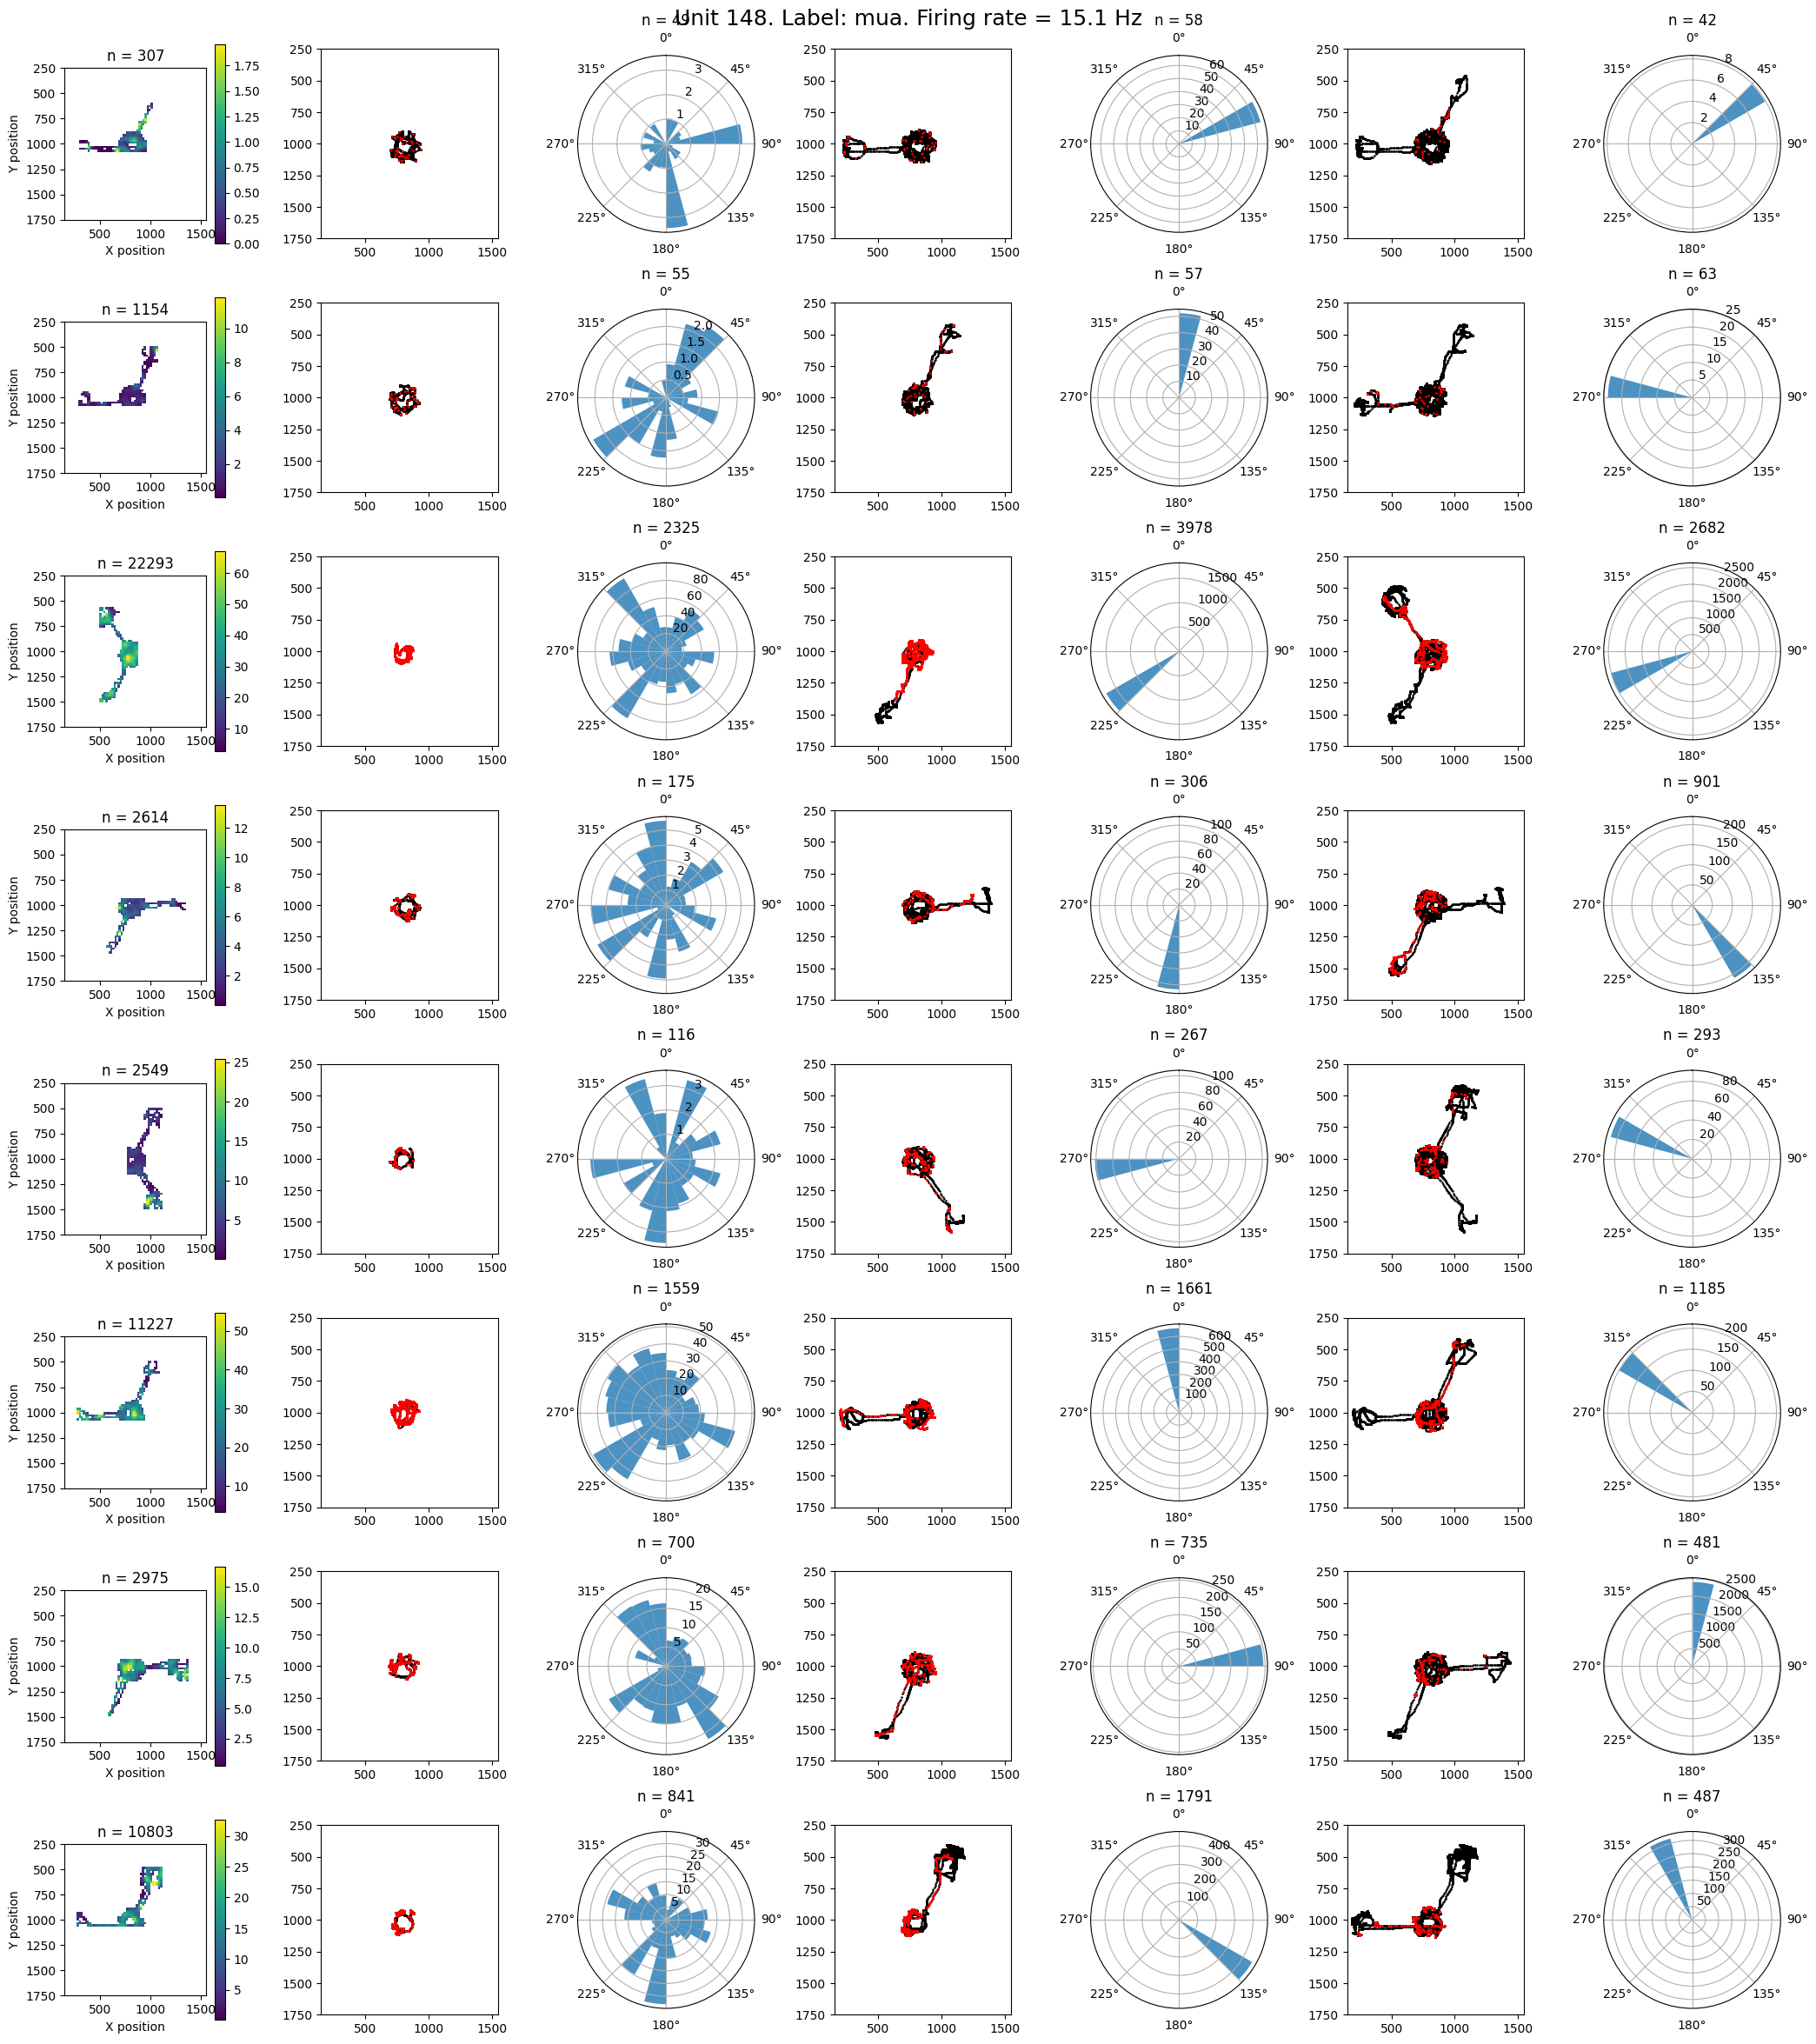

In [ ]:
unit_id = random.randint(300)

# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.round(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
print(f"total number of spikes fired {len(spike_train)}")
# Unit information
unit_firing_rate = 5
row = df_unit_metrics[df_unit_metrics['unit_ids'] == unit_id]

unit_firing_rate = row['firing_rate'].values[0]
unit_label = row['label'].values[0]

# Creating figure
fig, axs = plt.subplots(n_rows, n_cols, figsize = [3*n_cols, 3*n_rows])
axs = axs.flatten()
fig.suptitle(f"Unit {unit_id}. Label: {unit_label}. Firing rate = {unit_firing_rate:.1f} Hz", fontsize = 18)
counter = 0 # counts which axs we're on

trial_dur_so_far = 0
# Looping over trials
for tr in trials_to_include:
    spike_train_this_trial = np.copy(spike_train)
    # Trial times
    trial_row = epoch_times[(epoch_times.trialnumber == tr)]
    start_time = trial_row.iloc[0, 1]

    trial_length_row = trials_length[(trials_length.trialnumber == tr)]
    trial_length = trial_length_row.iloc[0, 2]
    # Positional data
    trial_csv_name = f'XY_HD_t{tr}.csv'
    trial_csv_path = os.path.join(pos_data_dir, trial_csv_name)
    xy_hd_trial = pd.read_csv(trial_csv_path)            
    xy = xy_hd_trial.iloc[:, :2].to_numpy().T
    x = xy_hd_trial.iloc[:, 0].to_numpy()
    y = xy_hd_trial.iloc[:, 1].to_numpy()
    hd = xy_hd_trial.iloc[:, 2].to_numpy()
    sync = np.arange(len(x))
    # Length of trial
    spike_train_this_trial =  [el for el in spike_train_this_trial if el > np.round(trial_dur_so_far+ start_time)*frame_rate] # filtering for current trial
    spike_train_this_trial = [el - trial_dur_so_far*frame_rate for el in spike_train_this_trial]
    spike_train_this_trial = [el for el in spike_train_this_trial if el < len(x)]

    # Make plots
    firing_rate_map, x_bins, y_bins, location_occupancy, _ = spatialheatmap(xy, spike_train_this_trial, sync, frame_rate, bin_size=20)
    plotspatialheatmap(firing_rate_map, x_bins, y_bins, ax = axs[counter])
    axs[counter].set_title(f"n = {len(spike_train_this_trial)}")
    counter += 1

    trial_dur_so_far += trial_length

    for e in range(1, n_epochs + 1):
        # Obtain epoch start and end times
        epoch_start = trial_row.iloc[0, 2*e-1]
        epoch_end = trial_row.iloc[0, 2*e]

        spike_train_this_epoch = [np.int32(el) for el in spike_train_this_trial if el > frame_rate*epoch_start and el < frame_rate *epoch_end]
        spike_train_this_epoch = np.asarray(spike_train_this_epoch, dtype=int)

        
        # spike plot
        x_until_now = x[:np.int32(epoch_end*frame_rate)]
        y_until_now = y[:np.int32(epoch_end*frame_rate)]
        axs[counter].scatter(x_until_now, y_until_now, color = 'black', s= 0.7)
        axs[counter].scatter(x[spike_train_this_epoch], y[spike_train_this_epoch], color = 'r', s= 0.7)
        axs[counter].set_xlim(150,1550)
        axs[counter].set_ylim(1750,250)

        axs[counter].set_aspect('equal', adjustable='box')
        counter += 1

        # HD calculations

        hd_this_epoch = hd[np.int32(epoch_start*frame_rate):np.int32(epoch_end*frame_rate)]
        hd_this_epoch = hd_this_epoch[~np.isnan(hd_this_epoch)]
        hd_this_epoch_rad = np.deg2rad(hd_this_epoch)
        occupancy_counts, _ = np.histogram(hd_this_epoch_rad, bins=72, range = [-np.pi, np.pi])
        occupancy_time = occupancy_counts / frame_rate 

        spikes_hd = hd[spike_train_this_epoch]
        spikes_hd = spikes_hd[~np.isnan(spikes_hd)]
        spikes_hd_rad = np.deg2rad(spikes_hd)
        counts, bin_edges = np.histogram(spikes_hd_rad, bins=72,range = [-np.pi, np.pi] )
        bin_idx = np.digitize(spikes_hd_rad, bin_edges) - 1  # zero-based index for Python

        direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)
        #bin_idx = np.clip(bin_idx, 0, len(direction_firing_rate) - 1)

        W = direction_firing_rate[bin_idx]

        # 6. Circular statistics
        MRL = resultant_vector_length(spikes_hd_rad, w=W)
        mu = circmean(spikes_hd_rad, weights=W)
        mean_angle_deg = np.rad2deg(mu)

        if np.isnan(MRL):
            raise ValueError "MRL is NAN"

        # Getting significance
        percentiles_95_value, percentiles_99_value = get_sig_cells(spike_train_this_epoch, hd, epoch_end - epoch_start)
        
        # Add significance data for every element (even if not significant)
        new_element = {
            'cell': unit_id,
            'trial': tr,
            'epoch': e,
            'MRL': MRL,
            'mean_direction': mu,
            'percentiles95': percentiles_95_value,
            'percentiles99': percentiles_99_value,
            'significant': 'ns', 
            'num_spikes': len(spike_train_this_epoch)
        }

        if MRL > percentiles_95_value:
            new_element['significant'] = 'sig'

        directional_data_all_units.loc[len(directional_data_all_units)] = new_element
        # Plot
        sync = np.arange(len(hd_this_epoch))
        fig.delaxes(axs[counter])
        axs[counter] = fig.add_subplot(n_rows, n_cols, counter+1, polar=True)
        headdir_bin_centers, firing_rate, headdir_occupancy = calculate_firing_rate_by_headdir(hd_this_epoch, spike_train_this_epoch, sync)
        headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
        width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

        headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)   # Your bin centers, in radians

        width = np.diff(headdir_bin_centers_rad)[0]
        # If using 24 bins (e.g., 15 degree bins), this will be 2*pi/24
        firing_rate[np.isnan(firing_rate)] = 0

        bars = axs[counter].bar(
            headdir_bin_centers_rad,
            firing_rate,
            width=width,
            bottom=0.0,
            alpha=0.8
        )
        axs[counter].set_theta_zero_location('N')
        axs[counter].set_theta_direction(-1)
        axs[counter].set_title(f"n = {len(spike_train_this_epoch)}")
        counter += 1 

        

output_dir = os.path.join(derivatives_base, 'analysis', 'cell_characteristics', 'spatial_features', 'spatial_plots', 'task_overview')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"unit_{unit_id}_spatiotemp.png")
#plt.savefig(output_path)
plt.show()
#plt.close(fig)



In [395]:
hd_this_epoch = hd[np.int32(epoch_start*frame_rate):np.int32(epoch_end*frame_rate)]
hd_this_epoch = hd_this_epoch[~np.isnan(hd_this_epoch)]
hd_this_epoch_rad = np.deg2rad(hd_this_epoch)
occupancy_counts, _ = np.histogram(hd_this_epoch_rad, bins=72, range = [-np.pi, np.pi])
occupancy_time = occupancy_counts / frame_rate 

spikes_hd = hd[spike_train_this_epoch]
spikes_hd = spikes_hd[~np.isnan(spikes_hd)]
spikes_hd_rad = np.deg2rad(spikes_hd)
counts, bin_edges = np.histogram(spikes_hd_rad, bins=72,range = [-np.pi, np.pi] )
bin_idx = np.digitize(spikes_hd_rad, bin_edges) - 1  # zero-based index for Python

direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)
#bin_idx = np.clip(bin_idx, 0, len(direction_firing_rate) - 1)

W = direction_firing_rate[bin_idx]

# 6. Circular statistics
MRL = resultant_vector_length(spikes_hd_rad, w=W)
mu = circmean(spikes_hd_rad, weights=W)
mean_angle_deg = np.rad2deg(mu)

In [403]:
MRL

0.0917024086502196

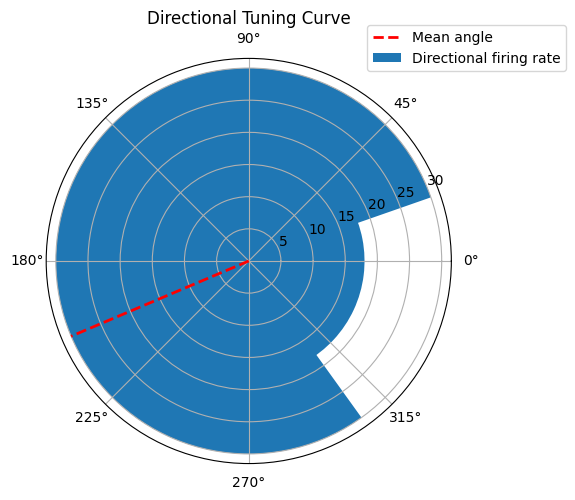

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the same bins as above
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 72 bin centers from -π to π

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))

# Plot directional tuning (occupancy-normalized firing rate)
ax.bar(bin_centers, direction_firing_rate, label='Directional firing rate', 

# Plot mean angle as a red arrow
ax.plot([mu_wrapped, mu_wrapped], [0, np.nanmax(direction_firing_rate)], color='r', linestyle='--', linewidth=2, label='Mean angle')

# Formatting
ax.set_title("Directional Tuning Curve")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [380]:
direction_firing_rate

array([ 7.17391304, 11.78571429,  8.        ,  5.        ,  3.15789474,
        3.52941176,  4.28571429,  8.33333333,  6.66666667,  5.88235294,
        8.73417722, 15.        ,  0.        ,  4.28571429,  5.45454545,
        0.        ,  5.        ,  6.66666667,  2.60869565,  2.72727273,
       10.5       ,  6.25      ,  1.93548387,  4.77272727,  1.66666667,
        0.        ,  7.5       ,  8.18181818, 10.        ,  9.        ,
        2.85714286, 15.        ,  6.66666667, 10.71428571,  5.17241379,
       10.15384615,  7.5       , 10.        ,  3.        , 15.        ,
        5.45454545, 10.        , 10.34482759,  6.42857143,  4.28571429,
        3.33333333,  6.66666667,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 18.        ,  6.        ,  5.45454545,
        9.375     ,  6.20689655, 12.63157895,  2.5       ,  4.46808511,
        7.5       ,  2.34375   ,  5.55555556,  4.28571429,  4.61538462,
        3.        , 12.        ,  0.        , 30.        ,  5.15

In [377]:
spike_train_this_epoch

array([13261, 13261, 13262, 13264, 13267, 13267, 13267, 13268, 13268,
       13270, 13271, 13272, 13272, 13272, 13273, 13275, 13278, 13280,
       13282, 13284, 13284, 13284, 13286, 13288, 13289, 13290, 13290,
       13291, 13293, 13294, 13294, 13294, 13294, 13294, 13295, 13297,
       13297, 13297, 13298, 13299, 13300, 13300, 13301, 13301, 13301,
       13302, 13302, 13304, 13305, 13305, 13306, 13306, 13309, 13310,
       13311, 13313, 13313, 13313, 13313, 13314, 13315, 13316, 13316,
       13316, 13318, 13319, 13319, 13320, 13321, 13321, 13322, 13322,
       13323, 13324, 13324, 13325, 13325, 13326, 13327, 13328, 13329,
       13332, 13332, 13332, 13334, 13335, 13340, 13341, 13342, 13342,
       13343, 13350, 13351, 13353, 13355, 13356, 13357, 13364, 13365,
       13366, 13372, 13373, 13382, 13391, 13392, 13393, 13402, 13404,
       13407, 13410, 13414, 13416, 13423, 13424, 13425, 13426, 13426,
       13426, 13431, 13431, 13439, 13442, 13447, 13447, 13452, 13452,
       13453, 13454,

In [369]:
# old vals
print(MRL, mu, mean_angle_deg)

nan nan nan


In [ ]:
import numpy as np
import random
import warnings

def get_sig_cells_here(spike_train_this_epoch, hd, epoch_dur = 1):
    num_shifts = 10000
    num_shifts = 20
    shift_min = 2*30
    shift_max = len(hd) - 20*30
    
    MRL_values = []


    current_data = spike_train_this_epoch
    current_angles = hd

    for shift_idx in range(num_shifts):
        # Get random shift value
        random_shift = random.randint(shift_min, shift_max)

        # Add or subtract the random_shift value from each element in the variable
        shifted_data = current_data + random_shift

        range_min = np.nanmin(current_data)
        range_max = np.nanmax(current_data)
        range_size = range_max - range_min + 1
        
        # Ensure shifted_data stays within the range [range_min, range_max]
        shifted_data = np.mod(shifted_data - range_min, range_size) + range_min
        
        # Calculate angles_degrees and MRL
        angles_degrees = current_angles[shifted_data]
        angles_radians = np.deg2rad(angles_degrees)
        mask = ~np.isnan(angles_radians)
        angles_radians= angles_radians[mask]
        MRL = resultant_vector_length(angles_radians)

        MRL_values.append( MRL)

    perc_95_val = np.percentile(MRL_values, 95)
    perc_99_val = np.percentile(MRL_values, 99)
    return perc_95_val, perc_99_val, MRL_values


def resultant_vector_length(alpha, w=None, d=None, axis=None,
                            axial_correction=1, ci=None, bootstrap_iter=None):
    """
    Copied from Pycircstat documentation
    Computes mean resultant vector length for circular data.

    This statistic is sometimes also called vector strength.

    :param alpha: sample of angles in radians
    :param w: number of incidences in case of binned angle data
    :param ci: ci-confidence limits are computed via bootstrapping,
               default None.
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :param bootstrap_iter: number of bootstrap iterations
                          (number of samples if None)
    :return: mean resultant length

    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    if axis is None:
        axis = 0
        alpha = alpha.ravel()
        if w is not None:
            w = w.ravel()

    cmean = _complex_mean(alpha, w=w, axis=axis,
                          axial_correction=axial_correction)

    # obtain length
    r = np.abs(cmean)

    # for data with known spacing, apply correction factor to correct for bias
    # in the estimation of r (see Zar, p. 601, equ. 26.16)
    if d is not None:
        if axial_correction > 1:
            warnings.warn("Axial correction ignored for bias correction.")
        r *= d / 2 / np.sin(d / 2)
    return r


def _complex_mean(alpha, w=None, axis=None, axial_correction=1):
    # Copied from picircstat documentation
    if w is None:
        w = np.ones_like(alpha)
    alpha = np.asarray(alpha)

    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape) \
                                   + " and w " + \
        str(w.shape) + " do not match!"

    return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
            np.sum(w, axis=axis))

In [ ]:
percentiles_95_value, percentiles_99_value, MRL_values = get_sig_cells_here(spike_train_this_epoch, hd)
percentiles_95_value

0.26604099185891217

In [ ]:
MRL_values

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

total number of spikes fired 4315


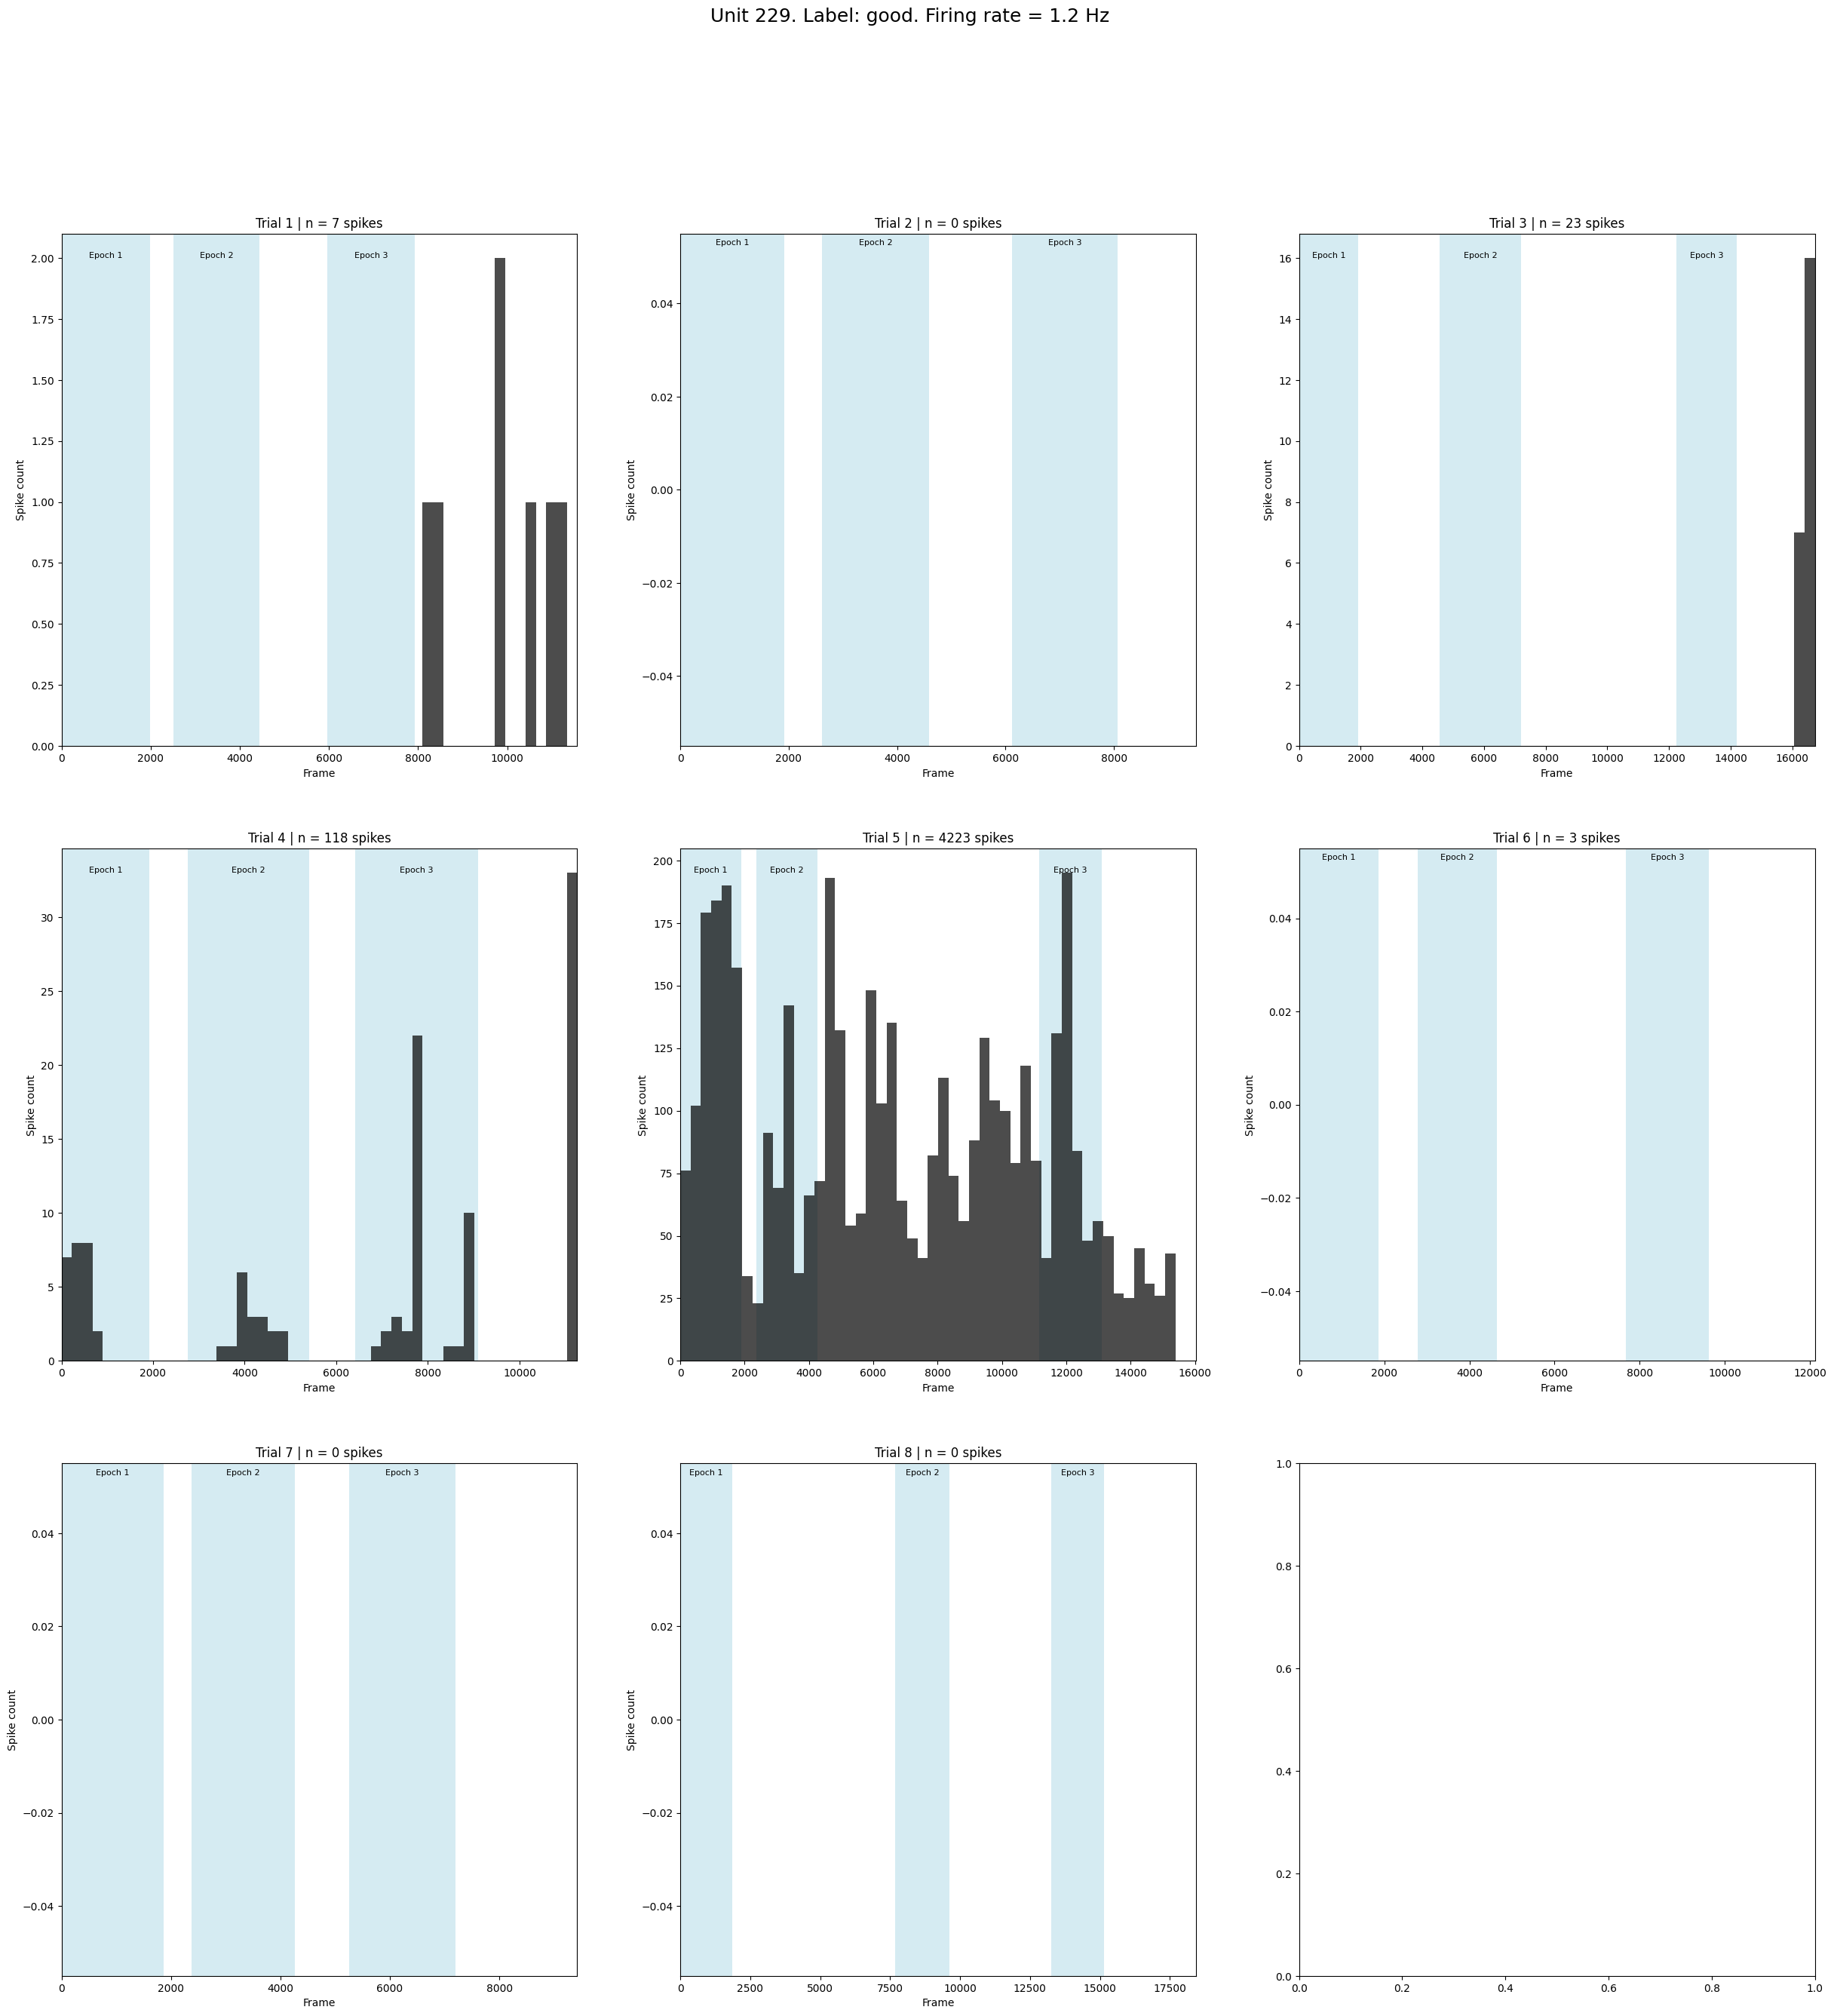

In [ ]:
unit_id = 229

# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.round(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
print(f"total number of spikes fired {len(spike_train)}")
# Unit information
unit_firing_rate = 5
row = df_unit_metrics[df_unit_metrics['unit_ids'] == unit_id]

unit_firing_rate = row['firing_rate'].values[0]
unit_label = row['label'].values[0]

# Creating figure
fig, axs = plt.subplots(3, 3, figsize = [30, 30])
axs = axs.flatten()
fig.suptitle(f"Unit {unit_id}. Label: {unit_label}. Firing rate = {unit_firing_rate:.1f} Hz", fontsize = 18)
counter = 0 # counts which axs we're on

trial_dur_so_far = 0
# Looping over trials
for tr in trials_to_include:
    spike_train_this_trial = np.copy(spike_train)
    # Trial times
    trial_row = epoch_times[(epoch_times.trialnumber == tr)]
    start_time = trial_row.iloc[0, 1]

    trial_length_row = trials_length[(trials_length.trialnumber == tr)]
    trial_length = trial_length_row.iloc[0, 2]
    # Positional data
    trial_csv_name = f'XY_HD_t{tr}.csv'
    trial_csv_path = os.path.join(pos_data_dir, trial_csv_name)
    xy_hd_trial = pd.read_csv(trial_csv_path)            
    xy = xy_hd_trial.iloc[:, :2].to_numpy().T
    x = xy_hd_trial.iloc[:, 0].to_numpy()
    y = xy_hd_trial.iloc[:, 1].to_numpy()
    hd = xy_hd_trial.iloc[:, 2].to_numpy()
    sync = np.arange(len(x))
    # Length of trial
    spike_train_this_trial =  [el for el in spike_train_this_trial if el > np.round(trial_dur_so_far+ start_time)*frame_rate] # filtering for current trial
    spike_train_this_trial = [el - trial_dur_so_far*frame_rate for el in spike_train_this_trial]
    spike_train_this_trial = [el for el in spike_train_this_trial if el < len(x)]

    # Make plots
    # === Histogram of spike times for this trial ===
    axs[counter].set_title(f"Trial {tr} | n = {len(spike_train_this_trial)} spikes")
        # Plot histogram of spike times
    axs[counter].hist(
        spike_train_this_trial,
        bins=50,
        range=(0, len(x)),
        color='black',
        alpha=0.7,
        zorder = 2
    )

    # Plot dotted lines for epoch start and end
    for e in range(1, n_epochs + 1):
        epoch_start = trial_row.iloc[0, 2*e - 1]
        epoch_end = trial_row.iloc[0, 2*e]

        axs[counter].axvspan(
            epoch_start*frame_rate,
            epoch_end*frame_rate,
            facecolor='lightblue',  # or 'lightblue'
            alpha=0.5,
            zorder = 0
        )
        epoch_mid = (epoch_start + epoch_end) *frame_rate/ 2

        # Add text label "Epoch {e}" at the midpoint
        axs[counter].text(
            epoch_mid,
            axs[counter].get_ylim()[1] *0.95,  # slightly above the top of the histogram
            f"Epoch {e}",
            ha='center',
            va='bottom',
            fontsize=8,
        )
    

    axs[counter].set_xlim(0, len(x))
    axs[counter].set_xlabel("Frame")
    axs[counter].set_ylabel("Spike count")
    counter += 1
    trial_dur_so_far += trial_length


output_dir = os.path.join(derivatives_base, 'analysis', 'cell_characteristics', 'spatial_features', 'spatial_plots', 'task_overview')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"unit_{unit_id}_spatiotemp.png")
#plt.savefig(output_path)
plt.show()
#plt.close(fig)




In [ ]:
def getAdaptiveMap(pos_binned, spk_binned, alpha=200/30):
    """
    Produces a ratemap that has been adaptively binned according to the
    algorithm described in Skaggs et al., 1996) [1]_.

    Parameters
    ----------
    pos_binned : np.ndarray
        The binned positional data.
    spk_binned : np.ndarray
        The binned spikes
    alpha : int, optional
        A scaling parameter determing the amount of occupancy to aim at
        in each bin. Defaults to 4. In the original paper this was set to 200.
        This is 4 here as the pos data is binned in seconds (the original data was in pos
        samples so this is a factor of 50 smaller than the original paper's value, given 50Hz sample rate)

    Returns
    -------
    tuple of np.ndarray
        The adaptively binned spike and pos maps.
        Use this to generate Skaggs information measure

    Notes
    -----
    Positions with high rates mean proportionately less error than those
    with low rates, so this tries to even the playing field. This type
    of binning should be used for calculations of spatial info
    as with the skaggs_info method in the fieldcalcs class (see below)
    alpha is a scaling parameter that might need tweaking for different
    data sets.

    The data [are] first binned
    into a 64 X 64 grid of spatial locations, and then the firing rate
    at each point in this grid was calculated by expanding a circle
    around the point until the following criterion was met:

    Nspks > alpha / (Nocc^2 * r^2)

    where Nspks is the number of spikes emitted in a circle of radius
    r (in bins), Nocc is the number of occupancy samples, alpha is the
    scaling parameter
    The firing rate in the given bin is then calculated as:

    sample_rate * (Nspks / Nocc)

    References
    ----------
    .. [1] W. E. Skaggs, B. L. McNaughton, K. M. Gothard & E. J. Markus
        "An Information-Theoretic Approach to Deciphering the Hippocampal
        Code"
        Neural Information Processing Systems, 1993.
    """
    #  assign output arrays
    smthdpos = np.zeros_like(pos_binned)
    smthdspk = np.zeros_like(spk_binned)
    smthdrate = np.zeros_like(pos_binned)
    idx = pos_binned == 0
    pos_binned[idx] = np.nan
    spk_binned[idx] = np.nan
    visited = np.zeros_like(pos_binned)
    visited[pos_binned > 0] = 1
    # array to check which bins have made it
    bincheck = np.isnan(pos_binned)
    r = 1
    while np.any(~bincheck):
        # create the filter kernel
        h = disk(radius = r)
        h[h >= np.max(h) / 3.0] = 1
        h[h != 1] = 0
        if h.shape >= pos_binned.shape:
            break
        # filter the arrays using astropys convolution
        filtpos = convolve(pos_binned, h)
        filtspk = convolve(spk_binned, h)
        filtvisited = convolve(visited, h)
        # get the bins which made it through this iteration
        truebins = alpha / (np.sqrt(filtspk) * filtpos) <= r
        truebins = np.logical_and(truebins, ~bincheck)
        # insert values where true
        smthdpos[truebins] = filtpos[truebins] / filtvisited[truebins]
        smthdspk[truebins] = filtspk[truebins] / filtvisited[truebins]
        bincheck[truebins] = True
        r += 1
    smthdrate = smthdspk / smthdpos
    smthdrate[idx] = np.nan
    smthdspk[idx] = np.nan
    smthdpos[idx] = np.nan
    return smthdrate, smthdspk, smthdpos

In [ ]:
def spatialheatmap(xycoords, spikes, sync, frame_rate = 30, bin_size=2, sigma=1):
    # Define the spatial bins
    x_bins = np.arange(np.nanmin(xycoords[0]), np.nanmax(xycoords[0]) + bin_size, bin_size)
    y_bins = np.arange(np.nanmin(xycoords[1]), np.nanmax(xycoords[1]) + bin_size, bin_size)

    # Calculate the occupancy map
    occupancy, _, _ = np.histogram2d(xycoords[0], xycoords[1], bins=[x_bins, y_bins])

    # Calculate the spike map
    spike_x = np.interp(spikes, sync, xycoords[0])
    spike_y = np.interp(spikes, sync, xycoords[1])
    spike_map, _, _ = np.histogram2d(spike_x, spike_y, bins=[x_bins, y_bins])

    # Normalize the spike map by the occupancy map to get the firing rate map
    # Avoid division by zero by setting occupancy bins with zero time to NaN
    firing_rate_map = np.divide(spike_map, occupancy, where=occupancy != 0)*frame_rate


    firing_rate_map = gaussian_filter(firing_rate_map, sigma=sigma, mode='constant', cval=np.nan)
    firing_rate_map[occupancy == 0] = np.nan
    return firing_rate_map, x_bins, y_bins, occupancy, spike_map

In [ ]:
def occupancy_map(xycoords, spikes, sync, num_bins,):
    # Occupancy time
    x = xycoords[0]
    y = xycoords[1]
    """
    x_edges = np.linspace(np.nanmin(x), np.nanmax(x), num_bins + 1)
    y_edges = np.linspace(np.nanmin(y), np.nanmax(y), num_bins + 1)
    """
    x_edges = np.linspace(np.nanmin(x), np.nanmax(x), num_bins + 1)
    y_edges = np.linspace(np.nanmin(y), np.nanmax(y), num_bins + 1) 
      
    occupancy, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])

    # Calculate the spike map
    spike_x = np.interp(spikes, sync, xycoords[0])
    spike_y = np.interp(spikes, sync, xycoords[1])
    spike_map, _, _ = np.histogram2d(spike_x, spike_y, bins=[x_edges, y_edges])
    return spike_map, occupancy, x_edges, y_edges

In [ ]:
def spatialheatmap_binsize(xycoords, spikes, sync, frame_rate = 30, bin_size=2, sigma=1, num_bins = 64):
    # Define the spatial bins
    x_bins = np.arange(np.nanmin(xycoords[0]), np.nanmax(xycoords[0]) + bin_size, bin_size)
    y_bins = np.arange(np.nanmin(xycoords[1]), np.nanmax(xycoords[1]) + bin_size, bin_size)
    
    x = xycoords[0]
    x = x[~np.isnan(x)]

    y = xycoords[1]
    y = y[~np.isnan(y)]
    # Calculate the occupancy map
    occupancy, _, _ = np.histogram2d(xycoords[0], xycoords[1], bins=[x_bins, y_bins])
    #occupancy, _, _ = np.histogram2d(x, y, num_bins)
    # Calculate the spike map
    spike_x = np.interp(spikes, sync, xycoords[0])
    spike_y = np.interp(spikes, sync, xycoords[1])

    spike_x = spike_x[~np.isnan(spike_x)]
    spike_y = spike_y[~np.isnan(spike_y)]

    spike_map, _, _ = np.histogram2d(spike_x, spike_y, bins=[x_bins, y_bins])
    #spike_map, x_bins, y_bins = np.histogram2d(spike_x, spike_y, num_bins)
    # Normalize the spike map by the occupancy map to get the firing rate map
    # Avoid division by zero by setting occupancy bins with zero time to NaN
    firing_rate_map = np.divide(spike_map, occupancy, where=occupancy != 0)*frame_rate


    firing_rate_map = gaussian_filter(firing_rate_map, sigma=sigma, mode='constant', cval=np.nan)
    firing_rate_map[occupancy == 0] = np.nan
    return firing_rate_map, x_bins, y_bins, occupancy, spike_map



def plotspatialheatmap(firing_rate_map, x_bins, y_bins, neuronname=None, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    cb = ax.imshow(
        firing_rate_map.T,
        origin='lower',
        aspect='auto',
        cmap='viridis',
        interpolation='none',
        extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]]
    )
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    if neuronname:
        ax.set_title(neuronname)
    ax.set_xlim(150,1550)
    ax.set_ylim(1750,250)
    ax.set_aspect('equal', adjustable='box')
    plt.colorbar(cb, ax=ax)
    plt.tight_layout()
    if ax is None:
        return fig, ax
    else:
        return ax


original length 4332
4332
4332
571


C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:78: RuntimeWarning: divide by zero encountered in divide
  truebins = alpha / (np.sqrt(filtspk) * filtpos) <= r
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:85: RuntimeWarning: invalid value encountered in divide
  smthdrate = smthdspk / smthdpos


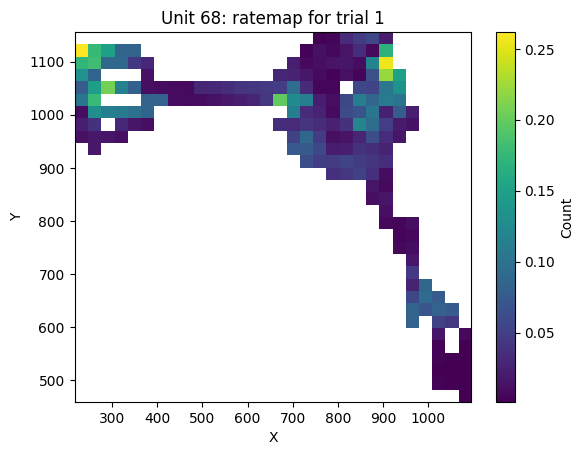

In [ ]:
"""
unit_id = 68
tr = 1

# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.round(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)
# Unit information
unit_firing_rate = 5
row = df_unit_metrics[df_unit_metrics['unit_ids'] == unit_id]

unit_firing_rate = row['firing_rate'].values[0]

trial_row = epoch_times[(epoch_times.trialnumber == tr)]
start_time = trial_row.iloc[0, 1]

# Positional data
trial_csv_name = f'XY_HD_t{tr}.csv'
trial_csv_path = os.path.join(pos_data_dir, trial_csv_name)
xy_hd_trial = pd.read_csv(trial_csv_path)            
xy = xy_hd_trial.iloc[:, :2].to_numpy().T
x = xy_hd_trial.iloc[:, 0].to_numpy()
y = xy_hd_trial.iloc[:, 1].to_numpy()
hd = xy_hd_trial.iloc[:, 2].to_numpy()
sync = np.arange(len(x))

print(f"original length {len(spike_train_org)}")
spike_train =  [el for el in spike_train if el > np.round(trial_dur_so_far+ start_time)] # filtering for current trial
print(len(spike_train))
spike_train = [el - trial_dur_so_far*frame_rate for el in spike_train] # shifting time spikes so they 0 is the start time of the trial
print(len(spike_train))
spike_train = [el for el in spike_train if el < len(x)]
print(len(spike_train))


sync = np.arange(len(xy[0]))
firing, occupance, x_edges, y_edges = occupancy_map(xy, spike_train, sync, num_bins = 30)
smthrate, smthdspk, smthdpos= getAdaptiveMap(occupance, firing, alpha=200/30)

plt.imshow(smthrate.T, origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='auto', cmap='viridis')
plt.colorbar(label='Count')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Unit {unit_id}: ratemap for trial {tr}')
plt.show()
"""


C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:78: RuntimeWarning: divide by zero encountered in divide
  truebins = alpha / (np.sqrt(filtspk) * filtpos) <= r
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:85: RuntimeWarning: invalid value encountered in divide
  smthdrate = smthdspk / smthdpos


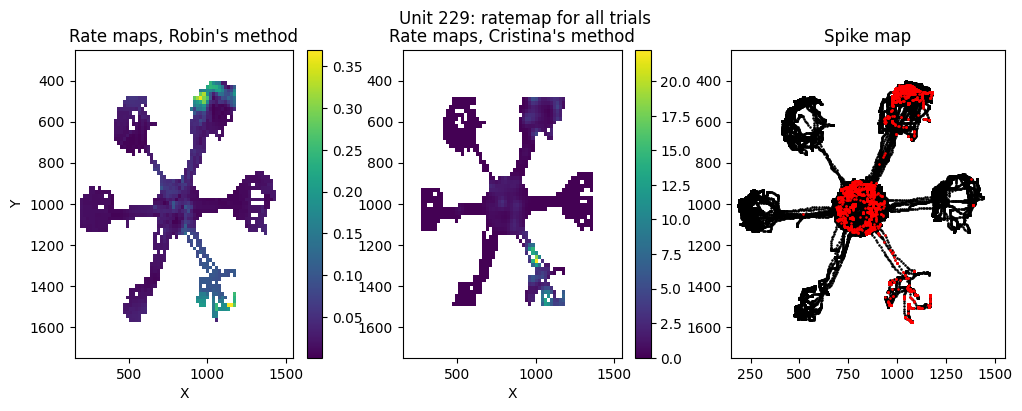

In [ ]:
# Extracting data for all trials

unit_id = 229
num_bins = 64
bin_size = (np.nanmax(x) - np.nanmin(x))/num_bins
alpha = 200/30 
# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)

# Unit information
unit_firing_rate = 5
row = df_unit_metrics[df_unit_metrics['unit_ids'] == unit_id]

unit_firing_rate = row['firing_rate'].values[0]

xy_hd_trial = pd.read_csv(r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_alltrials.csv")         
xy = xy_hd_trial.iloc[:, :2].to_numpy().T
x = xy_hd_trial.iloc[:, 0].to_numpy()
y = xy_hd_trial.iloc[:, 1].to_numpy()
hd = xy_hd_trial.iloc[:, 2].to_numpy()
sync = np.arange(len(x))



sync = np.arange(len(xy[0]))
firing, occupancy, x_edges, y_edges = occupancy_map(xy, spike_train, sync, num_bins)
smthrate, smthdspk, smthdpos = getAdaptiveMap(occupancy, firing, alpha=200)

fig, ax = plt.subplots(1, 3, figsize = (12,4))
ax = ax.flatten()
fig.suptitle(f'Unit {unit_id}: ratemap for all trials')
im = ax[0].imshow(smthrate.T, origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='auto', cmap='viridis', interpolation = None)
fig.colorbar(im, ax=ax[0])

# Set axis labels and title
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title("Rate maps, Robin's method")
ax[0].set_xlim(150,1550)
ax[0].set_ylim(1750,250)


firing_rate_map, x_bins, y_bins, location_occupancy, spike_map = spatialheatmap(xy, spike_train, sync, frame_rate, bin_size = bin_size)
im = ax[1].imshow(firing_rate_map.T, origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='auto', cmap='viridis', interpolation = None)
fig.colorbar(im, ax=ax[1])

# Set axis labels and title
ax[1].set_xlabel('X')
ax[1].set_title("Rate maps, Cristina's method")
ax[1].set_xlim(150,1550)
ax[1].set_ylim(1750,250)

ax[2].scatter(x, y, color = 'black', s= 0.7)
ax[2].scatter(x[spike_train], y[spike_train], color = 'r', s= 0.7)
ax[2].set_xlim(150,1550)
ax[2].set_ylim(1750,250)
ax[2].set_title('Spike map')

plt.show()


C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:78: RuntimeWarning: divide by zero encountered in divide
  truebins = alpha / (np.sqrt(filtspk) * filtpos) <= r
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:85: RuntimeWarning: invalid value encountered in divide
  smthdrate = smthdspk / smthdpos


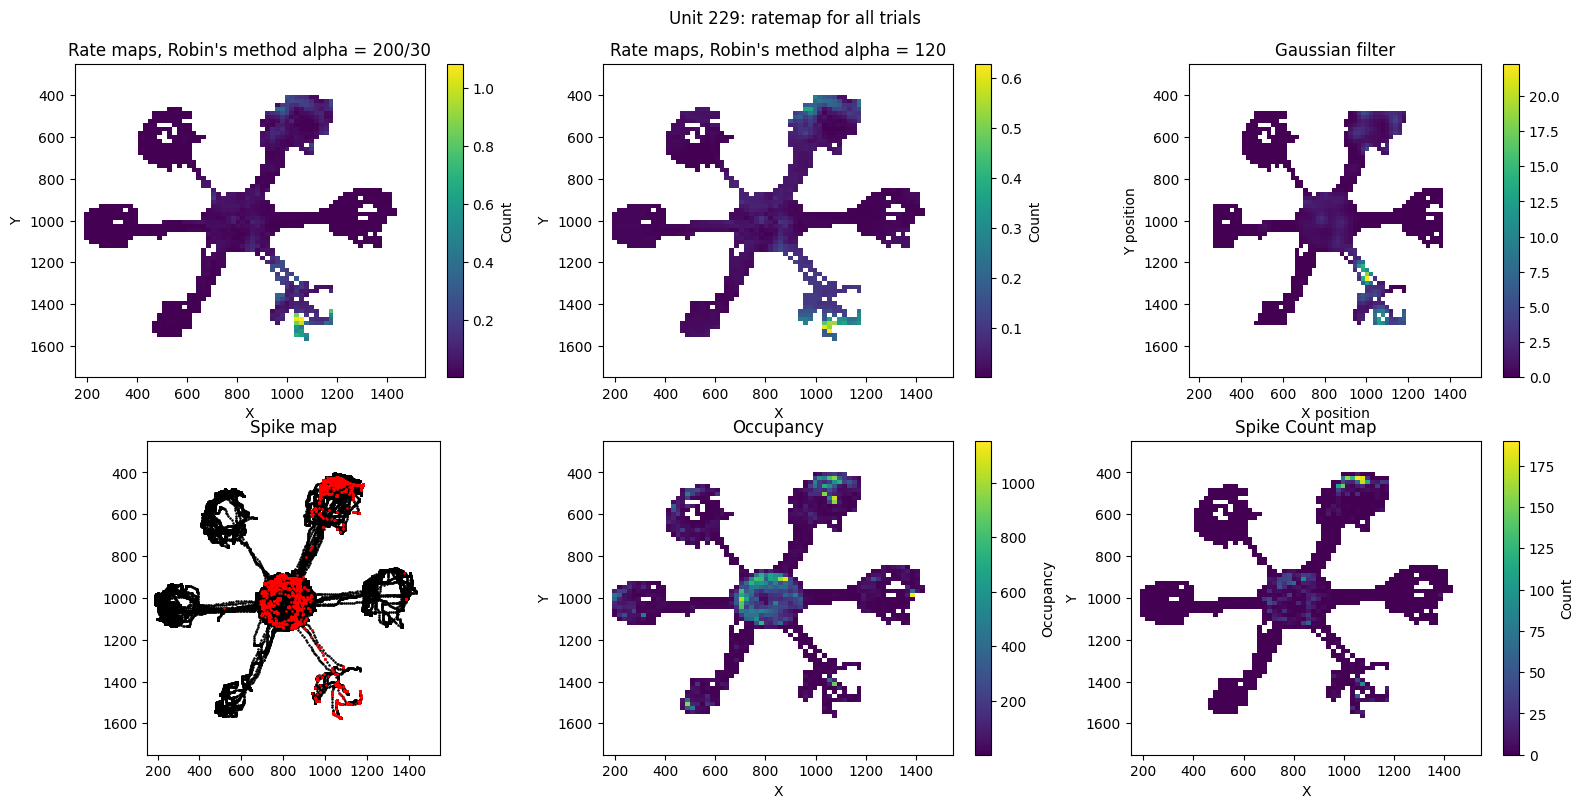

In [348]:
# Extracting data for all trials
from numpy import random
unit_id = 229
num_bins = 64
bin_size = (np.nanmax(x) - np.nanmin(x))/num_bins
alpha = 200/30
# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)

# Unit information
unit_firing_rate = 5
row = df_unit_metrics[df_unit_metrics['unit_ids'] == unit_id]

unit_firing_rate = row['firing_rate'].values[0]

xy_hd_trial = pd.read_csv(r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_alltrials.csv")         
xy = xy_hd_trial.iloc[:, :2].to_numpy().T
x = xy_hd_trial.iloc[:, 0].to_numpy()
y = xy_hd_trial.iloc[:, 1].to_numpy()
hd = xy_hd_trial.iloc[:, 2].to_numpy()
sync = np.arange(len(x))



sync = np.arange(len(xy[0]))
firing, occupancy, x_edges, y_edges = occupancy_map(xy, spike_train, sync, num_bins)
smthrate, smthdspk, smthdpos = getAdaptiveMap(location_occupancy, spike_map, alpha=alpha)

fig, ax = plt.subplots(2, 3, figsize = (16,8))
ax = ax.flatten()
fig.suptitle(f'Unit {unit_id}: ratemap for all trials')
im = ax[0].imshow(smthrate.T, origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='auto', cmap='viridis', interpolation = None)
fig.colorbar(im, ax=ax[0], label='Count')

# Set axis labels and title
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title("Rate maps, Robin's method alpha = 200/30")
ax[0].set_xlim(150,1550)
ax[0].set_ylim(1750,250)

firing_rate_map, x_bins, y_bins, location_occupancy, spike_map = spatialheatmap(xy, spike_train, sync, frame_rate, bin_size = bin_size)

smthrate, smthdspk, smthdpos = getAdaptiveMap(location_occupancy, spike_map, alpha=120)

im = ax[1].imshow(smthrate.T, origin='lower',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           aspect='auto', cmap='viridis', interpolation = None)
fig.colorbar(im, ax=ax[1], label='Count')

# Set axis labels and title
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title("Rate maps, Robin's method alpha = 120")
ax[1].set_xlim(150,1550)
ax[1].set_ylim(1750,250)




plotspatialheatmap(firing_rate_map, x_edges, y_edges, ax = ax[2])
ax[2].set_title('Gaussian filter')

ax[3].scatter(x, y, color = 'black', s= 0.7)
ax[3].scatter(x[spike_train], y[spike_train], color = 'r', s= 0.7)
ax[3].set_xlim(150,1550)
ax[3].set_ylim(1750,250)
ax[3].set_title('Spike map')
ax[3].set_aspect("equal")


# 7. Christina’s method imshow
im = ax[4].imshow(location_occupancy.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[4], label='Occupancy')
ax[4].set_title("Occupancy")
ax[4].set_xlabel('X')
ax[4].set_ylabel('Y')
ax[4].set_xlim(150, 1550)
ax[4].set_ylim(1750, 250)

# 8. Location occupancy
im = ax[5].imshow(spike_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[5], label='Count')
ax[5].set_title("Spike Count map")
ax[5].set_xlabel('X')
ax[5].set_ylabel('Y')
ax[5].set_xlim(150, 1550)
ax[5].set_ylim(1750, 250)

plt.show()


C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:78: RuntimeWarning: divide by zero encountered in divide
  truebins = alpha / (np.sqrt(filtspk) * filtpos) <= r
C:\Users\Sophia\AppData\Local\Temp\ipykernel_60668\1322362215.py:85: RuntimeWarning: invalid value encountered in divide
  smthdrate = smthdspk / smthdpos


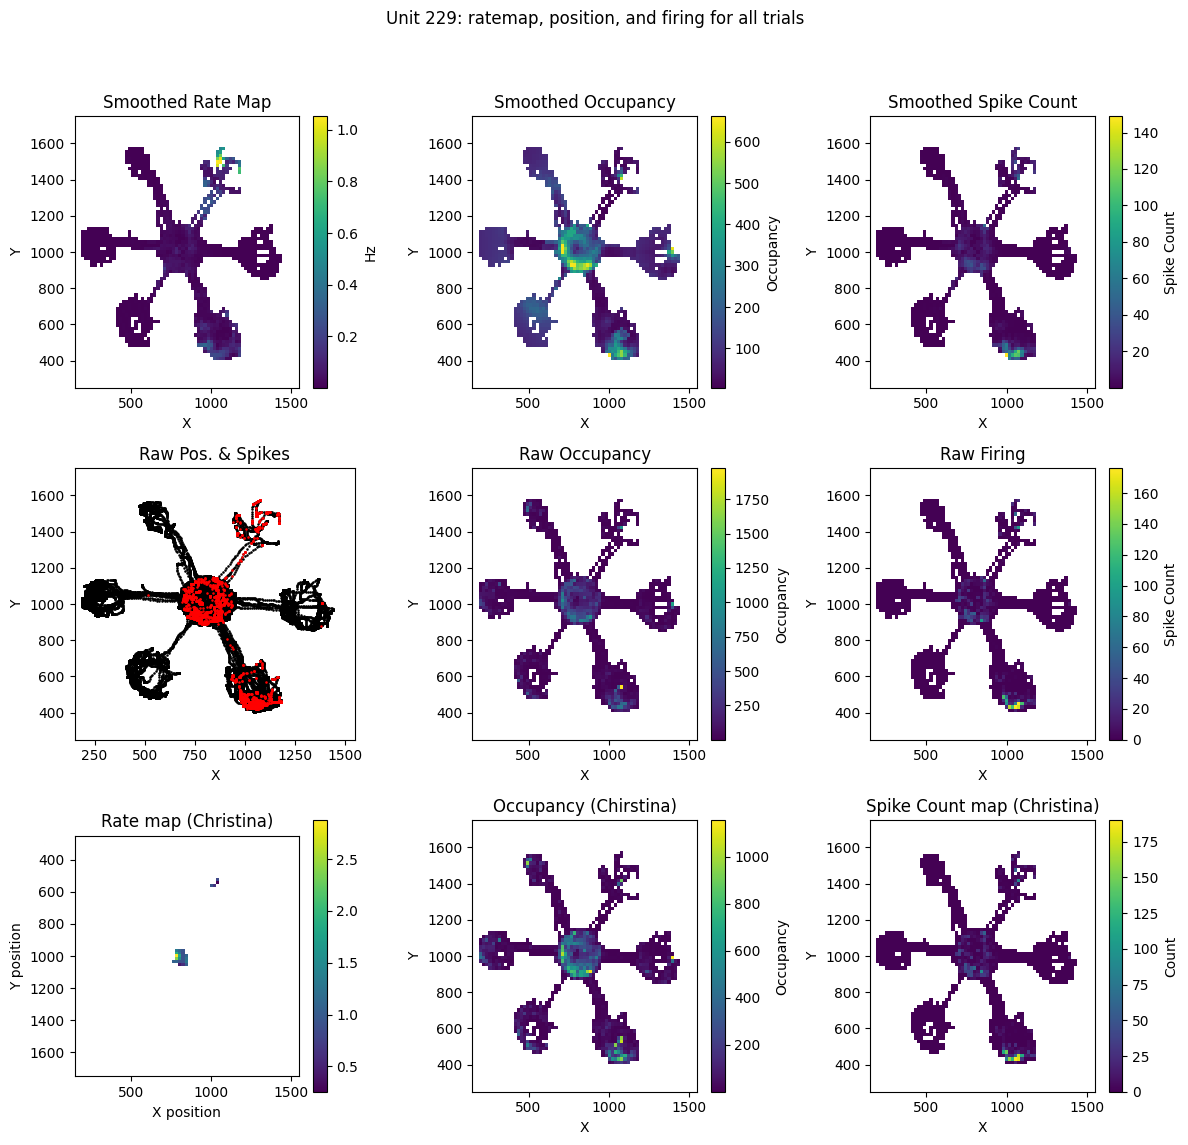

In [340]:
# Extracting data for all trials
firing, occupancy, x_edges, y_edges = occupancy_map(xy, spike_train, sync, num_bins)
smthrate, smthdspk, smthdpos = getAdaptiveMap(occupancy, firing, alpha=200/30)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = ax.flatten()
fig.suptitle(f'Unit {unit_id}: ratemap, position, and firing for all trials')

# 0. Smoothed ratemap
im = ax[0].imshow(smthrate.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[0], label='Hz')
ax[0].set_title("Smoothed Rate Map")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_xlim(150, 1550)
ax[0].set_ylim(250, 1750)

# 1. Smoothed occupancy
im = ax[1].imshow(smthdpos.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[1], label='Occupancy')
ax[1].set_title("Smoothed Occupancy")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_xlim(150, 1550)
ax[1].set_ylim(250, 1750)

# 2. Smoothed spikes
im = ax[2].imshow(smthdspk.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[2], label='Spike Count')
ax[2].set_title("Smoothed Spike Count")
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
ax[2].set_xlim(150, 1550)
ax[2].set_ylim(250, 1750)

# 3. Raw position + spikes
ax[3].scatter(x, y, color='black', s=0.7, label='Pos')
ax[3].scatter(x[spike_train], y[spike_train], color='r', s=0.7, label='Spikes')
ax[3].set_xlim(150, 1550)
ax[3].set_ylim(250, 1750)
ax[3].set_xlabel('X')
ax[3].set_ylabel('Y')
ax[3].set_title("Raw Pos. & Spikes")


# 4. Raw occupancy
im = ax[4].imshow(occupancy.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[4], label='Occupancy')
ax[4].set_title("Raw Occupancy")
ax[4].set_xlabel('X')
ax[4].set_ylabel('Y')
ax[4].set_xlim(150, 1550)
ax[4].set_ylim(250, 1750)

# 5. Raw firing
im = ax[5].imshow(firing.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[5], label='Spike Count')
ax[5].set_title("Raw Firing")
ax[5].set_xlabel('X')
ax[5].set_ylabel('Y')
ax[5].set_xlim(150, 1550)
ax[5].set_ylim(250, 1750)

firing_rate_map = np.divide(firing, occupancy, where=occupancy != 0)*frame_rate

firing_rate_map = gaussian_filter(firing_rate_map,sigma = 1,  mode='constant', cval=np.nan)
firing_rate_map[occupancy == 0] = np.nan

# 6. Christina’s method (custom plot)
plotspatialheatmap(firing_rate_map, x_edges, y_edges, ax=ax[6])
#plotspatialheatmap(firing_rate_map, x_edges, y_edges, ax=ax[6])

ax[6].set_title("Rate map (Christina)")

# 7. Christina’s method imshow
im = ax[7].imshow(location_occupancy.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[7], label='Occupancy')
ax[7].set_title("Occupancy (Chirstina)")
ax[7].set_xlabel('X')
ax[7].set_ylabel('Y')
ax[7].set_xlim(150, 1550)
ax[7].set_ylim(250, 1750)

# 8. Location occupancy
im = ax[8].imshow(spike_map.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                  aspect='auto', cmap='viridis')
fig.colorbar(im, ax=ax[8], label='Count')
ax[8].set_title("Spike Count map (Christina)")
ax[8].set_xlabel('X')
ax[8].set_ylabel('Y')
ax[8].set_xlim(150, 1550)
ax[8].set_ylim(250, 1750)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


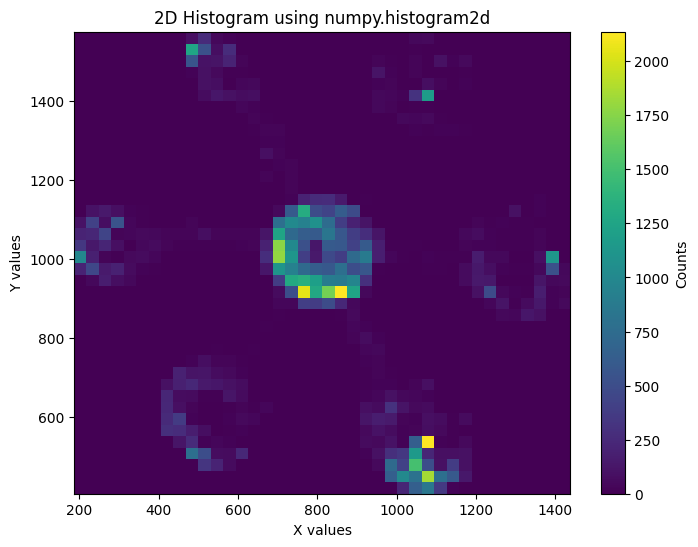

In [ ]:
x_no = x[~np.isnan(x)]
y_no = y[~np.isnan(y)]
hist, xedges, yedges = np.histogram2d(x_no, y_no, bins=40)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('2D Histogram using numpy.histogram2d')
plt.show()

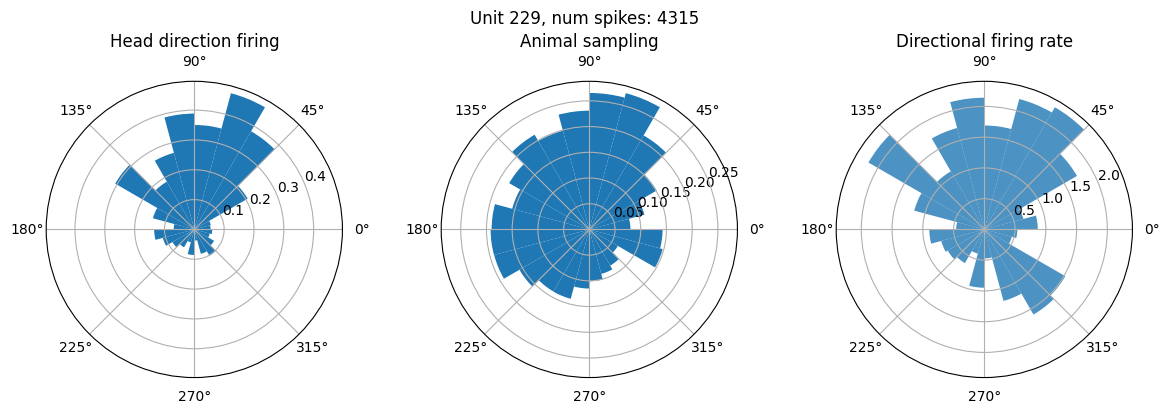

In [367]:
# 3 plots:
# Left: HD per bin
# Middle: Total spike count per HD:
# Right: Total sampling
from numpy import random
unit_id = random.randint(300)
unit_id = 229
num_bins = 64
bin_size = 1400/num_bins
# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)


hd_rad = np.deg2rad(hd)
fig, ax = plt.subplots(1, 3, figsize = (12,4), subplot_kw = {'projection': 'polar'})
fig.suptitle(f"Unit {unit_id}, num spikes: {len(spike_train)}")
headdir_bin_centers, firing_rate, headdir_occupancy = calculate_firing_rate_by_headdir(hd, spike_train, sync)
headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)   # Your bin centers, in radians

width = np.diff(headdir_bin_centers_rad)[0]
counter = 0
firing_rate[np.isnan(firing_rate)] = 0



# Total spikecount per hd
hd_count = hd[spike_train]
hd_rad_count = np.deg2rad(hd_count)
_, _, _ = ax[0].hist(hd_rad_count, bins = 24, density = True)
ax[0].set_title('Head direction firing')
# Total sampling for the day
n, bins, _= ax[1].hist(hd_rad, bins = 24, density = True)
ax[1].set_title('Animal sampling')

bars = ax[2].bar(
    headdir_bin_centers_rad,
    firing_rate,
    width=width,
    bottom=0.0,
    alpha=0.8
)
ax[2].set_title('Directional firing rate')
plt.tight_layout()
plt.show()